Propagation iterations: 77, goal distance: 77.0
Path found with 77 moves.


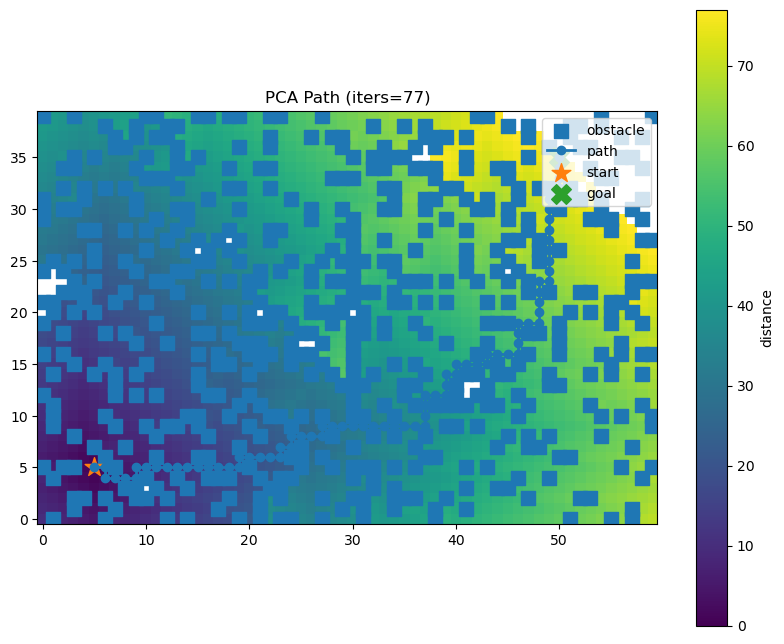

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def create_grid(height, width, obstacle_prob=0.2, seed=None):
    if seed is not None:
        np.random.seed(seed)
    grid = (np.random.rand(height, width) < obstacle_prob).astype(np.uint8)
    return grid

def set_obstacles_manual(grid, coords):
    for r,c in coords:
        if 0 <= r < grid.shape[0] and 0 <= c < grid.shape[1]:
            grid[r,c] = 1
    return grid

def ensure_free(grid, point):
    r,c = point
    if grid[r,c] == 1:
        grid[r,c] = 0
        return True
    return False

def pca_wavefront(grid, start, goal, max_iters=10000, neighborhood=4):
    h,w = grid.shape
    INF = 10**9
    dist = np.full((h,w), INF, dtype=np.int32)
    dist[grid == 1] = INF
    sr, sc = start
    gr, gc = goal
    dist[sr,sc] = 0

    if neighborhood == 8:
        nbrs = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
        # diagonal cost use 1 for simplicity (Manhattan-like); change to sqrt(2) if desired
    else:
        nbrs = [(-1,0),(1,0),(0,-1),(0,1)]

    for it in range(max_iters):
        candidate = np.full((h,w), INF, dtype=np.int32)
        # vectorized neighbor propagation by shifting
        for dr,dc in nbrs:
            shifted = np.full((h,w), INF, dtype=np.int32)
            rs_src = max(0, -dr); rs_dst = max(0, dr)
            re_src = h - max(0, dr); re_dst = h - max(0, -dr)
            cs_src = max(0, -dc); cs_dst = max(0, dc)
            ce_src = w - max(0, dc); ce_dst = w - max(0, -dc)
            shifted[rs_dst:re_dst, cs_dst:ce_dst] = dist[rs_src:re_src, cs_src:ce_src]
            shifted = shifted + 1  # uniform move cost
            shifted[grid == 1] = INF
            candidate = np.minimum(candidate, shifted)
        candidate[grid == 1] = INF
        candidate[sr,sc] = 0
        if np.array_equal(candidate, dist):
            break
        dist = candidate
        if dist[gr,gc] < INF:
            break

    dist_out = dist.astype(np.float32)
    dist_out[dist_out >= INF//2] = np.inf
    return dist_out, (it+1)

def backtrack_path(dist, start, goal, neighborhood=4):
    if np.isinf(dist[goal]):
        return None
    path = [goal]
    cur = goal
    if neighborhood == 8:
        nbrs = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    else:
        nbrs = [(-1,0),(1,0),(0,-1),(0,1)]
    max_steps = int(dist[goal] + 5)
    for _ in range(max_steps):
        if cur == start:
            break
        r,c = cur
        best = None
        best_val = np.inf
        for dr,dc in nbrs:
            nr, nc = r+dr, c+dc
            if 0 <= nr < dist.shape[0] and 0 <= nc < dist.shape[1]:
                v = dist[nr,nc]
                if v < best_val:
                    best_val = v
                    best = (nr,nc)
        if best is None or np.isinf(best_val):
            return None
        path.append(best)
        cur = best
    if path[-1] != start:
        return None
    path.reverse()
    return path

def plot_grid_and_path(grid, dist, path, start, goal, title=None):
    plt.figure(figsize=(10,8))
    disp = dist.copy()
    disp[np.isinf(disp)] = np.nan
    im = plt.imshow(disp, origin='upper', interpolation='nearest')
    obs = np.argwhere(grid==1)
    if len(obs) > 0:
        plt.scatter(obs[:,1], obs[:,0], marker='s', s=100, label='obstacle')
    if path is not None:
        py = [p[0] for p in path]; px = [p[1] for p in path]
        plt.plot(px, py, linewidth=2, marker='o', label='path')
    plt.scatter([start[1]], [start[0]], marker='*', s=200, label='start')
    plt.scatter([goal[1]], [goal[0]], marker='X', s=200, label='goal')
    plt.gca().invert_yaxis()
    plt.title(title or "PCA Wavefront Path Planning")
    plt.legend(loc='upper right')
    cbar = plt.colorbar(im); cbar.set_label('distance')
    plt.show()

# ---------------- Example usage ----------------
if __name__ == "__main__":
    H, W = 40, 60
    grid = create_grid(H, W, obstacle_prob=0.22, seed=2)

    # add manual vertical wall with gap
    for r in range(10, 30):
        grid[r, 30] = 1
    grid[20,30] = 0  # create a gap in the wall

    start = (5, 5)
    goal  = (35, 50)

    # Ensure start/goal are free (if they were accidentally inside obstacles)
    s_cleared = ensure_free(grid, start)
    g_cleared = ensure_free(grid, goal)
    if s_cleared or g_cleared:
        print("Warning: start or goal was inside an obstacle — cell(s) cleared to free.")

    dist, iters = pca_wavefront(grid, start, goal, max_iters=5000, neighborhood=4)
    print(f"Propagation iterations: {iters}, goal distance: {dist[goal]}")
    path = backtrack_path(dist, start, goal, neighborhood=4)
    if path is None:
        print("No path found.")
    else:
        print(f"Path found with {len(path)-1} moves.")
    plot_grid_and_path(grid, dist, path, start, goal, title=f"PCA Path (iters={iters})")
